In [1]:
import maup # mggg's library for proration, see documentation here: https://github.com/mggg/maup
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string

# VEST Georgia '16 Validation

## Examining and Loading Files

### VEST

#### VEST data file

In [2]:
vest_ga = gp.read_file("./raw-from-source/VEST/ga_2016/ga_2016.shp")

#From looking at the file and testing it, a unique ID of the county FIPS
# & the precinct name should work in most cases
print(vest_ga.head())

  DISTRICT CTYSOSID PRECINCT_I PRECINCT_N CTYNAME CTYNUMBER CTYNUMBER2 FIPS2  \
0  121JC15  121JC15       JC15       JC15  FULTON        60        060   121   
1  12108N1  12108N1       08N1       08N1  FULTON        60        060   121   
2  12108N2  12108N2       08N2       08N2  FULTON        60        060   121   
3  121JC14  121JC14       JC14       JC14  FULTON        60        060   121   
4  121JC05  121JC05       JC05       JC05  FULTON        60        060   121   

   G16PRERTRU  G16PREDCLI  G16PRELJOH  G16USSRISA  G16USSDBAR  G16USSLBUC  \
0         202         294          29         206         257          38   
1         313         232          32         445         133           6   
2         402         500          22         517         353          27   
3        1000         708          60        1199         497          39   
4         651         736          81         767         561          75   

   G16PSCRECH  G16PSCLHOS                               

#### VEST Data Sources (from documentation):

Election results from the Georgia Secretary of State Elections Division 
- https://sos.ga.gov/index.php/Elections/current_and_past_elections_results   

Precinct shapefile primarily from the Georgia General Assembly Reapportionment Office  
- http://www.legis.ga.gov/Joint/reapportionment/en-US/default.aspx

#### VEST Field Names (from documentation):

G16PRERTRU - Donald J. Trump (Republican Party)  
G16PREDCLI - Hillary Clinton (Democratic Party)  
G16PRELJOH - Gary Johnson (Libertarian Party)  
  
G16USSRISA - Johnny Isakson (Republican Party)  
G16USSDBAR - Jim Barksdale (Democratic Party)  
G16USSLBUC - Allen Buckley (Libertarian Party)  
  
G16PSCRECH - Tim Echols (Republican Party)  
G16PSCLHOS - Eric Hoskins (Libertarian Party)  

### Sourcefiles

Note: VEST writes in their documentation that they got their election results directly from the GA SOS office. The GA SOS site does not have a file with all of the precinct-level election resuls together in one place and we encountered errors in trying to download the data county-by-county so we have chosen to use MEDSL's precinct-level election results in their place.  

The relevant MEDSL election results are split across three different files:  
1. Presidential results at precinct-level 
2. State-level results at precinct-level
3. Senate results at precinct-level

#### MEDSL Presidential Election Precinct-Level Results

In [3]:
#Download file
medsl_election = pd.read_csv("./raw-from-source/MEDSL/2016-precinct-president.tab",sep="\t")

#Filter to only GA results
medsl_election= medsl_election[medsl_election.state=="Georgia"]

#Filter down to needed data
medsl_election= medsl_election[["county_name","county_fips",'jurisdiction', 'precinct', 'candidate','candidate_normalized', 'office', 'district', 'writein', 'party','mode', 'votes','candidate_fec', 'candidate_fec_name']]
candidate_list = ['CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE','JOHNSON, JOHN FITZGERALD MR.', 'TRUMP, DONALD J. / MICHAEL R. PENCE']
medsl_election=medsl_election[medsl_election["candidate_fec_name"].isin(candidate_list)]

#Clean the FIPS and precinct fields to use it as a unique ID
medsl_election['county_fips'] = medsl_election['county_fips'].astype(int)
medsl_election['county_fips'] = medsl_election['county_fips'].astype(str)
medsl_election["precinct"]=medsl_election["precinct"].str.strip()

#Create the unique ID
medsl_election['county_prec'] = medsl_election['county_fips'].str[2:5]+medsl_election["precinct"]

#Pivot the election results so each precinct has its own row
medsl_election=pd.pivot_table(medsl_election,index=['county_prec'],columns=["candidate_fec_name"],values=['votes'],aggfunc=sum)

#Clean up the index and the column names
medsl_election.columns = medsl_election.columns.droplevel(0)
medsl_election = medsl_election.rename(columns={"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE":"G16PREDCLI","JOHNSON, JOHN FITZGERALD MR.":"G16PRELJOH","TRUMP, DONALD J. / MICHAEL R. PENCE": "G16PRERTRU"})

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (13,17,19,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


#### MEDSL State Elections Precinct-Level Results

In [4]:
#Download file
medsl_state_election = pd.read_csv("./raw-from-source/MEDSL/2016-precinct-state.tab",sep="\t")

#Filter to only GA results
medsl_state_election= medsl_state_election[medsl_state_election.state=="Georgia"]

#Filter down to needed data
medsl_state_election= medsl_state_election[["county_name","county_fips",'jurisdiction', 'precinct', 'candidate','candidate_normalized', 'office', 'district', 'writein', 'party','mode', 'votes','candidate_fec', 'candidate_fec_name']]
medsl_state_election = medsl_state_election[medsl_state_election["office"]=="PUBLIC SERVICE COMMISSION, DISTRICT 2 - EASTERN"]

#Clean the FIPS and precinct fields to use it as a unique ID
medsl_state_election['county_fips'] = medsl_state_election['county_fips'].astype(int)
medsl_state_election['county_fips'] = medsl_state_election['county_fips'].astype(str)
medsl_state_election["precinct"]=medsl_state_election["precinct"].str.strip()

#Create the unique ID
medsl_state_election['county_prec'] = medsl_state_election['county_fips'].str[2:5]+medsl_state_election["precinct"]

#Pivot the election results so each precinct has its own row
medsl_state_election=pd.pivot_table(medsl_state_election,index=['county_prec'],columns=["candidate"],values=['votes'],aggfunc=sum)

#Clean up the index and the column names
medsl_state_election.columns = medsl_state_election.columns.droplevel(0)
medsl_state_election = medsl_state_election.rename(columns={"ERIC HOSKINS":"G16PSCLHOS","TIM ECHOLS":"G16PSCRECH"})

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (7,13,17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


#### MEDSL Senate Elections Precinct-Level Results

In [5]:
#Download file
medsl_senate_election = pd.read_csv("./raw-from-source/MEDSL/2016-precinct-senate.tab",sep="\t")

#Filter to only GA results and needed data
medsl_senate_election= medsl_senate_election[medsl_senate_election.state=="Georgia"]
medsl_senate_election= medsl_senate_election[["county_name","county_fips",'jurisdiction', 'precinct', 'candidate','candidate_normalized', 'office', 'district', 'writein', 'party','mode', 'votes','candidate_fec', 'candidate_fec_name']]

#Clean the FIPS and precinct fields and create the unique ID
medsl_senate_election['county_fips'] = medsl_senate_election['county_fips'].astype(int)
medsl_senate_election['county_fips'] = medsl_senate_election['county_fips'].astype(str)
medsl_senate_election["precinct"]=medsl_senate_election["precinct"].str.strip()
medsl_senate_election['county_prec'] = medsl_senate_election['county_fips'].str[2:5]+medsl_senate_election["precinct"]

#Pivot the election results so each precinct has its own row
medsl_senate_election=pd.pivot_table(medsl_senate_election,index=['county_prec'],columns=["candidate"],values=['votes'],aggfunc=sum)

#Clean up the index and the column names
medsl_senate_election.columns = medsl_senate_election.columns.droplevel(0)
medsl_senate_election = medsl_senate_election.drop('Michelle Gates', 1)
medsl_senate_election = medsl_senate_election.rename(columns={"ALLEN BUCKLEY":"G16USSLBUC","JIM BARKSDALE":"G16USSDBAR","JOHNNY ISAKSON":"G16USSRISA"})

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (13,19,27,30,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Check Totals

In [6]:
#Confirm that the totals of the data are the same
total_diff = abs(medsl_election["G16PREDCLI"].sum()-vest_ga["G16PREDCLI"].sum())+abs(medsl_election["G16PRELJOH"].sum()-vest_ga["G16PRELJOH"].sum()) +abs(medsl_election["G16PRERTRU"].sum()-vest_ga["G16PRERTRU"].sum()) +abs(medsl_state_election["G16PSCLHOS"].sum()-vest_ga["G16PSCLHOS"].sum())+abs(medsl_state_election["G16PSCRECH"].sum()-vest_ga["G16PSCRECH"].sum())+abs(medsl_senate_election["G16USSLBUC"].sum()-vest_ga["G16USSLBUC"].sum())+abs(medsl_senate_election["G16USSDBAR"].sum()-vest_ga["G16USSDBAR"].sum())+abs(medsl_senate_election["G16USSRISA"].sum()-vest_ga["G16USSRISA"].sum())
print("Total differences between MEDSL and VEST results by column: ", total_diff)

Total differences between MEDSL and VEST results by column:  0.0


### Merge MEDSL results

In [7]:
#Reset the indices of the 3 MEDSLfiles
medsl_election = medsl_election.reset_index()
medsl_state_election = medsl_state_election.reset_index()
medsl_senate_election = medsl_senate_election.reset_index()

#Check the shapes to make sure it is joinable
#print(medsl_election.shape)
#print(medsl_state_election.shape)
#print(medsl_senate_election.shape)

In [8]:
#Merge presidential and state election results
medsl_state_pres=pd.merge(medsl_election,medsl_state_election,on='county_prec',how='outer',indicator=False)

#Merged pres+state with senate results
medsl_all = pd.merge(medsl_state_pres,medsl_senate_election,on='county_prec',how='outer',indicator=True)

#Note, there are precincts that only have senate results
#These just appear to be write in columns without votes, drop those
print(medsl_all[medsl_all["_merge"]=="right_only"])

#Code showing that all values are NaN
print(medsl_all[medsl_all["_merge"]=="right_only"]["G16PRERTRU"].unique())

#Just use the columnns where it merged on both
medsl_final = medsl_all[medsl_all["_merge"]=="both"]

#Drop the merge column
medsl_final = medsl_final.drop('_merge', 1)

#Modify the unique ID to uppercase to help improve the join rate
medsl_final["county_prec"]=medsl_final["county_prec"].str.upper()

       county_prec  G16PREDCLI  G16PRELJOH  G16PRERTRU  G16PSCLHOS  \
2693  001Write-ins         NaN         NaN         NaN         NaN   
2694  009Write-ins         NaN         NaN         NaN         NaN   
2695  011Write-ins         NaN         NaN         NaN         NaN   
2696  015Write-ins         NaN         NaN         NaN         NaN   
2697  021Write-ins         NaN         NaN         NaN         NaN   
...            ...         ...         ...         ...         ...   
2759  293Write-ins         NaN         NaN         NaN         NaN   
2760  297Write-ins         NaN         NaN         NaN         NaN   
2761  303Write-ins         NaN         NaN         NaN         NaN   
2762  305Write-ins         NaN         NaN         NaN         NaN   
2763  321Write-ins         NaN         NaN         NaN         NaN   

      G16PSCRECH  G16USSLBUC  G16USSDBAR  G16USSRISA      _merge  
2693         NaN         NaN         NaN         NaN  right_only  
2694         NaN         

In [9]:
#Confirm the totals of the merge files match the original 3
total_diff = abs(medsl_election["G16PREDCLI"].sum()-medsl_final["G16PREDCLI"].sum())+abs(medsl_election["G16PRELJOH"].sum()-medsl_final["G16PRELJOH"].sum())+abs(medsl_election["G16PRERTRU"].sum()-medsl_final["G16PRERTRU"].sum())+abs(medsl_state_election["G16PSCLHOS"].sum()-medsl_final["G16PSCLHOS"].sum())+abs(medsl_state_election["G16PSCRECH"].sum()-medsl_final["G16PSCRECH"].sum())+abs(medsl_senate_election["G16USSLBUC"].sum()-medsl_final["G16USSLBUC"].sum())+abs(medsl_senate_election["G16USSDBAR"].sum()-medsl_final["G16USSDBAR"].sum())+abs(medsl_senate_election["G16USSRISA"].sum()-medsl_final["G16USSRISA"].sum())
print("Total differences between merged MEDSL and original MEDSL files: ", total_diff)

Total differences between merged MEDSL and original MEDSL files:  0.0


In [59]:
print(vest_ga.columns)

Index(['DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME',
       'CTYNUMBER', 'CTYNUMBER2', 'FIPS2', 'G16PRERTRU', 'G16PREDCLI',
       'G16PRELJOH', 'G16USSRISA', 'G16USSDBAR', 'G16USSLBUC', 'G16PSCRECH',
       'G16PSCLHOS', 'geometry'],
      dtype='object')


### Shapefiles

In [102]:
#Download the precinct shapefile
precinct_shapes_ga = gp.read_file("./raw-from-source/GA_shapefile/vtd2016-shape/VTD2016-Shape.shp")

#Filter down to needed columns
precinct_shapes_ga = precinct_shapes_ga.drop(['ID', 'AREA', 'DATA', 'COUNTY_NAM'],1)

#Create the unique ID
precinct_shapes_ga["county_prec"]=precinct_shapes_ga["FIPS2"].astype(str).str.zfill(3)+precinct_shapes_ga["PRECINCT_N"]

Index(['ID', 'AREA', 'DATA', 'POPULATION', 'DISTRICT', 'CTYSOSID',
       'PRECINCT_I', 'PRECINCT_N', 'CTYNUMBER', 'COUNTY', 'CTYNAME', 'FIPS1',
       'FIPS2', 'COUNTY_NAM', 'geometry'],
      dtype='object')


## Process and Merge the Shapefiles and Election Results

## VEST Processing (from documentation):

**1. IN PROGRESS (see below)**  
Fulton County uses shapefiles and maps sourced from the county GIS program. Precincts CH01/CH04B, CP07A/CP07D, SS29A/SS29B, UC031/UC035 were merged to match how voters were registered in the 2016 voter file.  
- Files needed: Fulton County GIS files  

**2. COMPLETED**  
The following precincts were split by congressional district to match the 2016 election results: Avondale High, Glennwood, Wadsworth in Dekalb County; Cates D in Gwinnett County.   
- Files needed: 2016 congressional map   

**3. PARTIALLY COMPLETED (see below)**  
Cloudland and Teloga precincts in Chattooga County were split along the ridgeline that marks the boundary between them with the USGS Topographic Contour shapefile.
- Files needed: USGS Topographic Contour shapefile      

**4. COMPLETED**   
Three of the four VTDs in Chattahoochee County are comprised of Fort Benning. However, the county only has one polling location for all voters, including residents of Fort Benning that vote within the county. The four Chattahoochee County VTDs have therefore been merged in the shapefile.  
- Files needed: n/a**  
- *Note: For whatever reason, this already seems to have been done on the files*

### Instruction 1

In [103]:
#Remove the Fulton precincts from the shapefile
precinct_shapes_ga = precinct_shapes_ga[~(precinct_shapes_ga["DISTRICT"].str[0:3]=="121")]

#Import the Fulton precincts
fulton_precincts = gp.read_file("./raw-from-source/Fulton_2016/Precincts2016.shp")

#Create a unique ID for the Fulton precincts
fulton_precincts['PRECINCT_N'] = fulton_precincts["VoterDist"]
fulton_precincts=fulton_precincts[['PRECINCT_N',"geometry"]]
fulton_precincts["county_prec"]="121"+fulton_precincts['PRECINCT_N']
fulton_precincts.to_crs(vest_ga.crs,inplace=True)

#Add columns to make append work
fulton_precincts['DISTRICT']=fulton_precincts["county_prec"]
fulton_precincts['CTYSOSID']=fulton_precincts["county_prec"]
fulton_precincts['PRECINCT_I']=fulton_precincts['PRECINCT_N']
fulton_precincts['CTYNAME']="Fulton"
fulton_precincts['CTYNUMBER']="60"
fulton_precincts['COUNTY']="060"
fulton_precincts['FIPS2']="121"

precinct_crs = precinct_shapes_ga.crs

precinct_shapes_ga = precinct_shapes_ga.append(fulton_precincts)

precinct_shapes_ga = gp.GeoDataFrame(precinct_shapes_ga, crs=precinct_crs)

In [104]:
print(precinct_shapes_ga[precinct_shapes_ga["county_prec"]=="121CH01"])

     POPULATION DISTRICT CTYSOSID PRECINCT_I PRECINCT_N CTYNUMBER COUNTY  \
273         NaN  121CH01  121CH01       CH01       CH01        60    060   

    CTYNAME FIPS1 FIPS2                                           geometry  \
273  Fulton   NaN   121  POLYGON ((-84.70760 33.57692, -84.70704 33.576...   

    county_prec  
273     121CH01  


    DISTRICT CTYSOSID PRECINCT_I PRECINCT_N CTYNAME CTYNUMBER CTYNUMBER2  \
348  121CH01  121CH01       CH01       CH01  FULTON        60        060   

    FIPS2  G16PRERTRU  G16PREDCLI  G16PRELJOH  G16USSRISA  G16USSDBAR  \
348   121          44         107           6          43         102   

     G16USSLBUC  G16PSCRECH  G16PSCLHOS  \
348           5          59          78   

                                              geometry  
348  MULTIPOLYGON (((-84.71472 33.57614, -84.71471 ...  
Empty GeoDataFrame
Columns: [DISTRICT, CTYSOSID, PRECINCT_I, PRECINCT_N, CTYNAME, CTYNUMBER, CTYNUMBER2, FIPS2, G16PRERTRU, G16PREDCLI, G16PRELJOH, G16USSRISA, G16USSDBAR, G16USSLBUC, G16PSCRECH, G16PSCLHOS, geometry]
Index: []


AttributeError: 'PatchCollection' object has no property 'geometry'

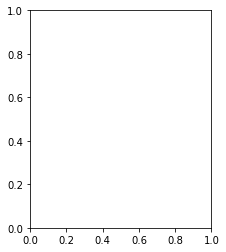

In [105]:
#Merge Precincts CH01/CH04B
print(vest_ga[vest_ga["DISTRICT"]=="121CH01"])
print(vest_ga[vest_ga["DISTRICT"]=="121CH04B"])

#New name should be CH01
shape_fort = precinct_shapes_ga.loc[precinct_shapes_ga["county_prec"]=="121CH01"]
shape_fort_1 = precinct_shapes_ga.loc[precinct_shapes_ga["county_prec"]=="121CH04B"]


shape_fort.plot(geometry="geometry")

drop_index = precinct_shapes_ga[precinct_shapes_ga["county_prec"]=="121CH04B"].index.values[0]
prec2combine = [shape_fort,shape_fort_1]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = shape_fort.crs)
shape_fort["geometry"]=new_fort.unary_union
fulton_precincts = precinct_shapes_ga.drop([drop_index])

shape_fort.plot()
vest_ga[vest_ga["DISTRICT"]=="121CH01"].plot()

     DISTRICT  CTYSOSID PRECINCT_I PRECINCT_N CTYNAME CTYNUMBER CTYNUMBER2  \
337  121CP07A  121CP07A      CP07A      CP07A  FULTON        60        060   

    FIPS2  G16PRERTRU  G16PREDCLI  G16PRELJOH  G16USSRISA  G16USSDBAR  \
337   121          10         441          10          28         373   

     G16USSLBUC  G16PSCRECH  G16PSCLHOS  \
337          17          60         323   

                                              geometry  
337  POLYGON ((-84.47732 33.64665, -84.48463 33.646...  
Empty GeoDataFrame
Columns: [DISTRICT, CTYSOSID, PRECINCT_I, PRECINCT_N, CTYNAME, CTYNUMBER, CTYNUMBER2, FIPS2, G16PRERTRU, G16PREDCLI, G16PRELJOH, G16USSRISA, G16USSDBAR, G16USSLBUC, G16PSCRECH, G16PSCLHOS, geometry]
Index: []


/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


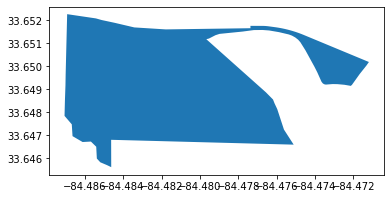

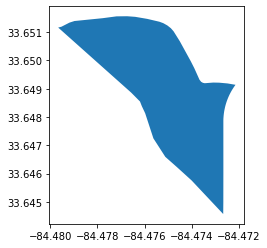

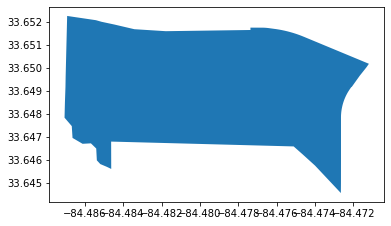

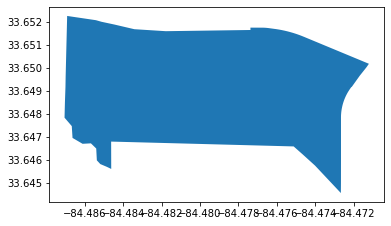

In [52]:
#Merge Precincts CP07A/CP07D
print(vest_ga[vest_ga["DISTRICT"]=="121CP07A"])
print(vest_ga[vest_ga["DISTRICT"]=="121CP07D"])

#New name should be CP07A
shape_fort = fulton_precincts.loc[fulton_precincts["county_prec"]=="121CP07A"]
shape_fort_1 = fulton_precincts.loc[fulton_precincts["county_prec"]=="121CP07D"]

shape_fort.plot()
shape_fort_1.plot()

drop_index = fulton_precincts[fulton_precincts["county_prec"]=="121CP07D"].index.values[0]
prec2combine = [shape_fort,shape_fort_1]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = shape_fort.crs)
shape_fort["geometry"]=new_fort.unary_union
fulton_precincts = fulton_precincts.drop([drop_index])

shape_fort.plot()
vest_ga[vest_ga["DISTRICT"]=="121CP07A"].plot()

     DISTRICT  CTYSOSID PRECINCT_I PRECINCT_N CTYNAME CTYNUMBER CTYNUMBER2  \
303  121SS29A  121SS29A      SS29A      SS29A  FULTON        60        060   

    FIPS2  G16PRERTRU  G16PREDCLI  G16PRELJOH  G16USSRISA  G16USSDBAR  \
303   121         681         966          86         861         761   

     G16USSLBUC  G16PSCRECH  G16PSCLHOS  \
303          75         987         533   

                                              geometry  
303  POLYGON ((-84.34855 33.96047, -84.34772 33.961...  
Empty GeoDataFrame
Columns: [DISTRICT, CTYSOSID, PRECINCT_I, PRECINCT_N, CTYNAME, CTYNUMBER, CTYNUMBER2, FIPS2, G16PRERTRU, G16PREDCLI, G16PRELJOH, G16USSRISA, G16USSDBAR, G16USSLBUC, G16PSCRECH, G16PSCLHOS, geometry]
Index: []


/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


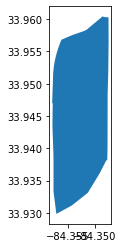

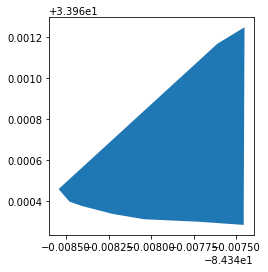

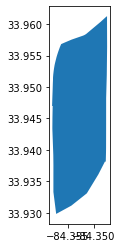

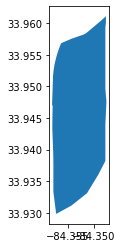

In [53]:
#Merge Precincts SS29A/SS29B
print(vest_ga[vest_ga["DISTRICT"]=="121SS29A"])
print(vest_ga[vest_ga["DISTRICT"]=="121SS29B"])

#New name should be SS29A
shape_fort = fulton_precincts.loc[fulton_precincts["county_prec"]=="121SS29A"]
shape_fort_1 = fulton_precincts.loc[fulton_precincts["county_prec"]=="121SS29B"]

shape_fort.plot()
shape_fort_1.plot()

drop_index = fulton_precincts[fulton_precincts["county_prec"]=="121SS29B"].index.values[0]
prec2combine = [shape_fort,shape_fort_1]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = shape_fort.crs)
shape_fort["geometry"]=new_fort.unary_union
fulton_precincts = fulton_precincts.drop([drop_index])

shape_fort.plot()
vest_ga[vest_ga["DISTRICT"]=="121SS29A"].plot()

     DISTRICT  CTYSOSID PRECINCT_I PRECINCT_N CTYNAME CTYNUMBER CTYNUMBER2  \
304  121UC031  121UC031      UC031      UC031  FULTON        60        060   

    FIPS2  G16PRERTRU  G16PREDCLI  G16PRELJOH  G16USSRISA  G16USSDBAR  \
304   121         281        1019          25         313         904   

     G16USSLBUC  G16PSCRECH  G16PSCLHOS  \
304          28         378         686   

                                              geometry  
304  POLYGON ((-84.51393 33.55938, -84.51390 33.559...  
Empty GeoDataFrame
Columns: [DISTRICT, CTYSOSID, PRECINCT_I, PRECINCT_N, CTYNAME, CTYNUMBER, CTYNUMBER2, FIPS2, G16PRERTRU, G16PREDCLI, G16PRELJOH, G16USSRISA, G16USSDBAR, G16USSLBUC, G16PSCRECH, G16PSCLHOS, geometry]
Index: []


/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


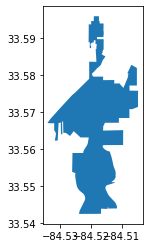

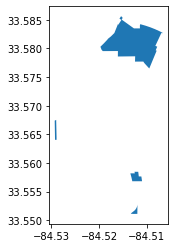

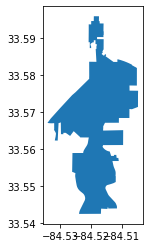

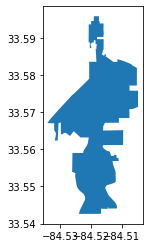

In [54]:
#Merge Precincts UC031/UC035
print(vest_ga[vest_ga["DISTRICT"]=="121UC031"])
print(vest_ga[vest_ga["DISTRICT"]=="121UC035"])

#New name should be UC031
shape_fort = fulton_precincts.loc[fulton_precincts["county_prec"]=="121UC031"]
shape_fort_1 = fulton_precincts.loc[fulton_precincts["county_prec"]=="121UC035"]

shape_fort.plot()
shape_fort_1.plot()

drop_index = fulton_precincts[fulton_precincts["county_prec"]=="121UC035"].index.values[0]
prec2combine = [shape_fort,shape_fort_1]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = shape_fort.crs)
shape_fort["geometry"]=new_fort.unary_union
fulton_precincts = fulton_precincts.drop([drop_index])

shape_fort.plot()
vest_ga[vest_ga["DISTRICT"]=="121UC031"].plot()

### Instruction 2

#### Import Congressional File and grab needed GA districts

In [ ]:
#Upload the districts and filter down to just Georgia
us_congress = gp.read_file("./raw-from-source/Congressional_Districts/tl_2018_us_cd116/tl_2018_us_cd116.shp")
ga_congress = us_congress[us_congress["STATEFP"]=="13"]

#Grab the needed districts for these splits
district_4 = ga_congress.loc[[91]]
district_5 = ga_congress.loc[[92]]
district_7 = ga_congress.loc[[98]]
district_4["geometry"]=district_4.buffer(0)
district_5["geometry"]=district_5.buffer(0)
district_7["geometry"]=district_7.buffer(0)
district_4.to_crs(precinct_shapes_ga.crs,inplace=True)
district_5.to_crs(precinct_shapes_ga.crs,inplace=True)
district_7.to_crs(precinct_shapes_ga.crs,inplace=True)

#### 1. Avondale

In [ ]:
#Locate the avondale precinct and its index
avondale_high = precinct_shapes_ga[precinct_shapes_ga["PRECINCT_N"]=="AVONDALE HIGH"]
avondale_index = precinct_shapes_ga[precinct_shapes_ga["PRECINCT_N"]=="AVONDALE HIGH"].index.values[0]

#Calculate the intersection
avondale_high_4 = gp.overlay(district_4,avondale_high, how='intersection',keep_geom_type=False)
avondale_high_5 = gp.overlay(district_5,avondale_high, how='intersection',keep_geom_type=False)

#Filter down columns
avondale_high_4 = avondale_high_4[['ID', 'AREA', 'DATA', 'POPULATION', 'DISTRICT', 'CTYSOSID','PRECINCT_I', 'PRECINCT_N', 'CTYNUMBER', 'COUNTY', 'CTYNAME', 'FIPS1','FIPS2', 'COUNTY_NAM', 'geometry', 'county_prec']]
avondale_high_5 = avondale_high_4[['ID', 'AREA', 'DATA', 'POPULATION', 'DISTRICT', 'CTYSOSID','PRECINCT_I', 'PRECINCT_N', 'CTYNUMBER', 'COUNTY', 'CTYNAME', 'FIPS1','FIPS2', 'COUNTY_NAM', 'geometry', 'county_prec']]

#Rename the "county_prec"
avondale_high_4['county_prec']="089AVONDALE HIGH - 04"
avondale_high_5['county_prec']="089AVONDALE HIGH - 05"

#Add the new files to the dataframe
precinct_shapes_ga = precinct_shapes_ga.append(avondale_high_4)
precinct_shapes_ga = precinct_shapes_ga.append(avondale_high_5)

#Drop the old precinct
precinct_shapes_ga = precinct_shapes_ga.drop([avondale_index])

#### 2. Glennwood

In [ ]:
#Locate the glennwood precinct and its index
glennwood = precinct_shapes_ga[precinct_shapes_ga["PRECINCT_N"]=="GLENNWOOD (DEC)"]
glennwood_index = precinct_shapes_ga[precinct_shapes_ga["PRECINCT_N"]=="GLENNWOOD (DEC)"].index.values[0]

#Calculate the intersection
glennwood_4 = gp.overlay(district_4,glennwood, how='intersection',keep_geom_type=False)
glennwood_5 = gp.overlay(district_5,glennwood, how='intersection',keep_geom_type=False)

#Filter down columns
glennwood_4 = glennwood_4[['ID', 'AREA', 'DATA', 'POPULATION', 'DISTRICT', 'CTYSOSID','PRECINCT_I', 'PRECINCT_N', 'CTYNUMBER', 'COUNTY', 'CTYNAME', 'FIPS1','FIPS2', 'COUNTY_NAM', 'geometry', 'county_prec']]
glennwood_5 = glennwood_5[['ID', 'AREA', 'DATA', 'POPULATION', 'DISTRICT', 'CTYSOSID','PRECINCT_I', 'PRECINCT_N', 'CTYNUMBER', 'COUNTY', 'CTYNAME', 'FIPS1','FIPS2', 'COUNTY_NAM', 'geometry', 'county_prec']]

#Rename the "county_prec"
glennwood_4['county_prec']="089GLENNWOOD - 04"
glennwood_5['county_prec']="089GLENNWOOD - 05"

#Add the new files to the dataframe
precinct_shapes_ga = precinct_shapes_ga.append(glennwood_4)
precinct_shapes_ga = precinct_shapes_ga.append(glennwood_5)

#Drop the old precinct
precinct_shapes_ga = precinct_shapes_ga.drop([glennwood_index])

#### 3. Wadsworth

In [ ]:
#Locate the wadsworth precinct and its index
wadsworth = precinct_shapes_ga[precinct_shapes_ga["PRECINCT_N"]=="WADSWORTH"]
wadsworth_index = precinct_shapes_ga[precinct_shapes_ga["PRECINCT_N"]=="WADSWORTH"].index.values[0]

#Calculate the intersection
wadsworth_4 = gp.overlay(district_4,wadsworth, how='intersection',keep_geom_type=False)
wadsworth_5 = gp.overlay(district_5,wadsworth, how='intersection',keep_geom_type=False)

#Filter down columns
wadsworth_4 = wadsworth_4[['ID', 'AREA', 'DATA', 'POPULATION', 'DISTRICT', 'CTYSOSID','PRECINCT_I', 'PRECINCT_N', 'CTYNUMBER', 'COUNTY', 'CTYNAME', 'FIPS1','FIPS2', 'COUNTY_NAM', 'geometry', 'county_prec']]
wadsworth_5 = wadsworth_5[['ID', 'AREA', 'DATA', 'POPULATION', 'DISTRICT', 'CTYSOSID','PRECINCT_I', 'PRECINCT_N', 'CTYNUMBER', 'COUNTY', 'CTYNAME', 'FIPS1','FIPS2', 'COUNTY_NAM', 'geometry', 'county_prec']]
 
#Rename the "county_prec"
wadsworth_4['county_prec']="089WADSWORTH - 04"
wadsworth_5['county_prec']="089WADSWORTH - 05"

#Add the new files to the dataframe
precinct_shapes_ga = precinct_shapes_ga.append(wadsworth_4)
precinct_shapes_ga = precinct_shapes_ga.append(wadsworth_5)

#Drop the old precinct
precinct_shapes_ga = precinct_shapes_ga.drop([wadsworth_index])

#### 4. Cates

In [ ]:
#Locate the Cates precinct and its index
cates_d = precinct_shapes_ga[precinct_shapes_ga["PRECINCT_N"]=="CATES D"]
cates_d_index = precinct_shapes_ga[precinct_shapes_ga["PRECINCT_N"]=="CATES D"].index.values[0]

#Calculate the intersection
cates_d_4 = gp.overlay(district_4,cates_d, how='intersection',keep_geom_type=False)
cates_d_7 = gp.overlay(district_7,cates_d, how='intersection',keep_geom_type=False)

#Filter down columns
cates_d_4 = cates_d_4[['ID', 'AREA', 'DATA', 'POPULATION', 'DISTRICT', 'CTYSOSID','PRECINCT_I', 'PRECINCT_N', 'CTYNUMBER', 'COUNTY', 'CTYNAME', 'FIPS1','FIPS2', 'COUNTY_NAM', 'geometry', 'county_prec']]
cates_d_7 = cates_d_7[['ID', 'AREA', 'DATA', 'POPULATION', 'DISTRICT', 'CTYSOSID','PRECINCT_I', 'PRECINCT_N', 'CTYNUMBER', 'COUNTY', 'CTYNAME', 'FIPS1','FIPS2', 'COUNTY_NAM', 'geometry', 'county_prec']]

#Rename the "county_prec"
cates_d_4['county_prec']="135CATES D"
cates_d_7['county_prec']="135035 CATES D - 04"

#Add the new files to the dataframe
precinct_shapes_ga = precinct_shapes_ga.append(cates_d_4)
precinct_shapes_ga = precinct_shapes_ga.append(cates_d_7)

#Drop the old precinct
precinct_shapes_ga = precinct_shapes_ga.drop([cates_d_index])

### Instruction 3:

This instruction involved splitting the Cloudland Teloga precinct on a certain ridgeline. Loading VEST's final file as well as the precinct shapefile into a GIS sofware gave us confirmation that they indeed split the precinct on the ridgeline. 

In [ ]:
#Printing with the merged precinct on top
ax2 = precinct_shapes_ga[precinct_shapes_ga["CTYSOSID"]=="055XC-968"].plot(zorder=2)
vest_ga[vest_ga["PRECINCT_N"]=="CLOUDLAND"].plot(ax=ax2,color="red")
vest_ga[vest_ga["PRECINCT_N"]=="TELOGA"].plot(ax=ax2,color="orange")

#Printing with the split precincts on top
ax = precinct_shapes_ga[precinct_shapes_ga["CTYSOSID"]=="055XC-968"].plot()
vest_ga[vest_ga["PRECINCT_N"]=="CLOUDLAND"].plot(ax=ax,color="red")
vest_ga[vest_ga["PRECINCT_N"]=="TELOGA"].plot(ax=ax,color="orange")

#Import the topo lines
elev_contour_1 = gp.read_file("./raw-from-source/Topographic_Lines/VECTOR_Dougherty_Gap_GA_7_5_Min_Shape/Elev_Contour.shp")
elev_contour_2 = gp.read_file("./raw-from-source/Topographic_Lines/VECTOR_Jamestown_AL_7_5_Min_Shape/Elev_Contour.shp")

#Plot the elev_countours
ax3 = elev_contour_1.plot(linewidth=0.1)
elev_contour_2.plot(ax=ax3,linewidth=0.1)
minx, miny, maxx, maxy = precinct_shapes_ga[precinct_shapes_ga["CTYSOSID"]=="055XC-968"].total_bounds
ax3.set_xlim(minx, maxx)
ax3.set_ylim(miny, maxy)

#Confirm that the precincts are really split on a ridgeline
ax4 = vest_ga[vest_ga["PRECINCT_N"]=="CLOUDLAND"].plot(color="red")
vest_ga[vest_ga["PRECINCT_N"]=="TELOGA"].plot(ax=ax4,color="orange")
elev_contour_1.plot(ax=ax4,linewidth=0.1)
elev_contour_2.plot(ax=ax4,linewidth=0.1)
minx, miny, maxx, maxy = precinct_shapes_ga[precinct_shapes_ga["CTYSOSID"]=="055XC-968"].total_bounds
ax4.set_xlim(minx, maxx)
ax4.set_ylim(miny, maxy)

#As you can see the precinct is not plotted exactly on 

In [ ]:
print(cloudland_teloga)

### Instruction 4:


In [ ]:
shape_fort = precinct_shapes_ga.loc[precinct_shapes_ga["county_prec"]=="053ACTIVITY CENTER"]
shape_fort_1 = precinct_shapes_ga[precinct_shapes_ga["DISTRICT"]=="053FTBEN1"]
shape_fort_2 = precinct_shapes_ga[precinct_shapes_ga["DISTRICT"]=="053FTBEN2"]
shape_fort_3 = precinct_shapes_ga[precinct_shapes_ga["DISTRICT"]=="053FTBEN3"]

index_fort_1 = precinct_shapes_ga[precinct_shapes_ga["DISTRICT"]=="053FTBEN1"].index.values[0]
index_fort_2 = precinct_shapes_ga[precinct_shapes_ga["DISTRICT"]=="053FTBEN2"].index.values[0]
index_fort_3 = precinct_shapes_ga[precinct_shapes_ga["DISTRICT"]=="053FTBEN3"].index.values[0]

prec2combine = [shape_fort,shape_fort_1,shape_fort_2,shape_fort_3]

new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = shape_fort.crs)
shape_fort["geometry"]=new_fort.unary_union

precinct_shapes_ga = precinct_shapes_ga.drop([index_fort_1,index_fort_2,index_fort_3])

**Increasing Matches: Changes to MEDSL names**

In [ ]:
changes_dict = {'321SYLVER EAST' : '321SYLVESTER EAST',
'317SENIOR CITIZEN CENTER' : '317SENIOR CITIZEN CENTE',
'317METASVILLE FIRE STATION' : '317METASVILLE FIRE STA',
'315ROCHELLE SOUTH 4' : '315ROCHELLE SOUTH #4',
'315ROCHELLE NORTH 1' : '315ROCHELLE NORTH #1',
'315PITTS 3' : '315PITTS #3',
'315PINEVIEW 2' : '315PINEVIEW #2',
'315ABBEVILLE SOUTH 5' : '315ABBEVILLE SOUTH #5',
'315ABBEVILLE NORTH 2' : '315ABBEVILLE NORTH #2',
'311MT. YONAH' : '311MT YONAH',
'305MT. PLEASANT' : '305MT PLEASANT',
'295LAFAYETTE' : '295LA FAYETTE',
'279514 S.T.I.A.L.C' : '279514 S.T.I.A.L.C.',
'27939 NEW BRANCH' : '27939 NEWBRANCH',
'277MOTT-LITTMAN GYM' : '277MOTT-LITMAN GYM',
'275MERRILLVILLE' : '275MERRILVILLE',
'275FIRE STATION 2' : '275FIRE STATION #2',
'269#6 REYNOLDS' : '269PRECINCT 6',
'269#5 COURTHOUSE' : '269PRECINCT 5',
'269#1 BUTLER FIRE DEPT.' : '269PRECINCT 1',
'261ANDERSONV' : '261ANDERSONVILLE',
'251SCREVEN REC DEPT' : '251SCREVEN REC. DEPT.',
'247STANTON' : '247ST',
'247ST. PIUS' : '247SP',
'247SMYRNA' : '247SM',
'247SHEFFIELD' : '247SH',
'247SALEM' : '247SA',
'247ROCKDALE' : '247RO',
'247OLDE TOWNE' : '247OT',
'247MILSTEAD' : '247MI',
'247MAGNET' : '247MA',
'247LORRAINE' : '247LO',
'247THE LAKES' : '247LA',
'247HIGHTOWER' : '247HI',
'247HONEY CREEK' : '247HC',
'247FLAT SHOALS' : '247FS',
'247FIELDSTONE' : '247FI',
'247CONYERS' : '247CO',
'247BETHEL' : '247BT',
'247BARKSDALE' : '247BA',
'243FOUNTAIN BRIDGE-4TH' : '243FOUNTAIN BRIDGE',
'241RABUN' : '241RABUN COUNTY',
'215ST PETER U. M. C.' : '215ST. PETER',
'215NATIONAL INFANTRY' : '215NATIONAL INFANTRY MUSEUM',
'215ST. MARK/HEIFERHORN' : '215ST MARK/HEIFERHORN',
'215ST. ANDREWS/MIDLAND' : '215ST ANDREWS/MIDLAND',
'215MT. PILGRIM' : '215MT PILGRIM',
'215GALLOPS/HANNAN' : '215MARIANNA GALLOPS',
'215CORNERSTONE CHURCH' : '215CORNERSTONE',
'215BRITT DAVID BAPT CH' : '215BRITT DAVID',
'211WEST MORGAN' : '2116. WEST MORGAN',
'211NORTHEAST MORGAN' : '2111. NORTHEAST MORGAN',
'211NORTH MORGAN' : '2117. NORTH MORGAN',
'211EAST MORGAN' : '2112. EAST MORGAN',
'211CLACKS CHAPEL' : '2115. CLACKS CHAPEL',
'211CENTRAL MORGAN' : '2114. CENTRAL MORGAN',
'211BETH/SPRINGFIELD' : '2113. BETH/SPRINGFIELD',
'205HISONTON' : '205HINSONTON',
'199WOODBURY' : '199LOWER 9TH-WOODBURY',
'199WARM SPRINGS' : '1992ND-WARM SPRINGS',
'199ODESSADALE' : '1997TH-ODESSADALE',
'199MANCHESTER GILL II' : '199GILL II',
'199MANCHESTER GILL I' : '199GILL I',
'199GREENVILLE' : '1998TH-GREENVILLE',
'199GAY' : '199MIDDLE 9TH-GAY',
'199DURAND' : '199THIRD-DURAND',
'199ALVATON' : '199UPPER 9TH -ALVATON',
'197FT. PERRY' : '197FORT PERRY',
'193MONTEZUMA 5' : '193MONTEZUMA #5',
'193MONTEZUMA 4' : '193MONTEZUMA #4',
'179LIBERTY COUNTY' : '179LIBERTY COUNTY COMPLEX',
'179HINESVILLE LODGE' : '179HINESVILLE LODGE 271',
'177SOVEREIGN GRACE' : '177#8 SOVEREIGN GRACE',
'177SMITHVILLE' : '177#2 SMITHVILLE',
'177SDA CHURCH' : '177#7 SDA CHURCH',
'177REDBONE' : '177#10 REDBONE',
'177LEESBURG' : '177#4 LEESBURG',
'177FRIENDSHIP BAPT' : '177#5 FRIENDSHIP BAPT.',
'177FIRST BAPTIST' : '177#6 FIRST BAPTIST',
'177CJC' : '177#3 CJC',
'177CHOKEE' : '177#1 CHOKEE',
'177CENTURY FIRE STATION' : '177#9 CENTURY FIRE STAT',
'175LCFS 10 (VALAMBROSIA)' : '175LCFS #10 (VALAMBROSIA)',
'175FAMILY LIFE CENTER' : '175FBC - FLC',
'171SENIOR CITZEN BLDG' : '171SENIOR CITIZEN BLDG',
'161HAZELHURST' : '161HAZLEHURST',
'157SOUTH MINISH' : '157S MINISH',
'157SOUTH JEFFERSON' : '157S JEFFERSON',
'157NORTH MINISH' : '157N MINISH',
'157NORTH JEFFERSON' : '157N JEFFERSON',
'151MT. CARMEL' : '151MOUNT CARMEL',
'141MAYFIELD COMM CENTER' : '141MAYFIELD COMMUNITY CENTER',
'13931-FRIENDSHIP IV' : '139FRIENDSHIP IV',
'13930-FRIENDSHIP III' : '139FRIENDSHIP III',
'13929-FRIENDSHIP II' : '139FRIENDSHIP II',
'13928-FRIENDSHIP I' : '139FRIENDSHIP I',
'13927-BIG HICKORY' : '139BIG HICKORY',
'13926-GILLSVILLE' : '139GILLSVILLE',
'13925-GAINESVILLE V' : '139GAINESVILLE V',
'13924-GAINESVILLE IV' : '139GAINESVILLE IV',
'13923-GAINESVILLE III' : '139GAINESVILLE III',
'13922-GAINESVILLE II' : '139GAINESVILLE II',
'13921-GAINESVILLE I' : '139GAINESVILLE I',
'13920-WEST WHELCHEL' : '139WEST WHELCHEL',
'13919-WHELCHEL' : '139WHELCHEL',
'13918-FORK' : '139FORK',
'13917-CHESTATEE' : '139CHESTATEE',
'13916-BARK CAMP' : '139BARK CAMP',
'13915-QUILLIANS' : '139QUILLIANS',
'13914-CLERMONT' : '139CLERMONT',
'13913-LULA' : '139LULA',
'13912-GLADE' : '139GLADE',
'13911-TADMORE' : '139TADMORE',
'13910-CANDLER' : '139CANDLER',
'13909-MORGAN II' : '139MORGAN II',
'13908-MORGAN I' : '139MORGAN I',
'13907-ROBERTS' : '139ROBERTS',
'13906-FLOWERY BRANCH II' : '139FLOWERY BRANCH II',
'13905-FLOWERY BRANCH I' : '139FLOWERY BRANCH I',
'13904-OAKWOOD II' : '139OAKWOOD II',
'13903-OAKWOOD I' : '139OAKWOOD I',
'13902-CHICOPEE' : '139CHICOPEE',
'13901-WILSON' : '139WILSON',
'131CAIRO 5TH DISTRICT' : '131CAIRO 5TH DISTR',
'131CAIRO 4TH DISTRICT' : '131CAIRO 4TH DISTR',
'127STERLING ELEM SCHOOL' : '127STERLING ELEMENTARY',
'127STERLING CHURCH OF GOD' : '127STERLING CH. OF GOD',
'127BURROUGHS' : '127BURROUGHS MOLETTE',
'127BALLARD COMPLEX' : '127BALLARD COMMUNITY BUILDING',
'099LUCILLE' : '099LUCILE',
'097FIRST BAPTIST CHURCH' : '097FIRST BAPTIST DOUGLASVILLE',
'097FIRST BAPTIST - LITHIA SPRINGS' : '097FIRST BAPTIST LITHIA SPRINGS',
'097DAY STAR' : '097DAY STAR GYM',
'097COUNTY LINE BAPTIST CHURCH' : '097COUNTY LINE BAPTIST',
'097CHURCH-CH' : '097CHURCH AT CHAPEL HILL',
'097BEULAH' : '097BEULAH BAPTIST CHURCH',
'095SHILOH BAPTIST CHURCH' : '095SHILOH BAPTIST CHURC',
'095SECOND MT. ZION' : '0952ND MT ZION CHURCH',
'095PUTNEY 1ST BAPT CHURCH' : '095PUTNEY 1ST BAPT CHUR',
'095PINE BLUFF BAPT CHURCH' : '095PINE BLUFF BAPT CHUR',
'095PHOEBE EDU. BLDG' : '095PHOEBE EDUCATION BLD',
'095PALMYRA RD METH CHURCH' : '095PALMYRA METH CHURCH',
'095MT. ZION CENTER' : '095MT ZION CENTER',
'095LAMAR REESE ELEM SCHOOL' : '095LAMAR REESE ELEM SCH',
'095FIRST CHRISTIAN CHURCH' : '0951ST CHRISTIAN CHURCH',
'095COVENANT PRES CHURCH' : '095COVENANT CHURCH',
'091YONKER' : '091YONKE',
'091VILULA' : '091VILUL',
'091RAWLINS' : '091RAWLI',
'091PONDTOWN' : '091PONDT',
'091PLAINFIELD' : '091PLAIN',
'091MULLIS' : '091MULLI',
'091MITCHELL' : '091MITCH',
'091MCCRANIE' : '091MCCRA',
'091JAYBIRD' : '091JAYBI',
'091EMPIRE' : '091EMPIR',
'091CHAUNCEY' : '091CHAUN',
'089WOODWARD ELEM' : '089WOODWARD (BHAVN)',
'089WINTERS CHAPEL' : '089WINTERS CHAPEL (DUN)',
'089WINNONA PARK ELEM' : '089WINNONA PARK ELEM (DEC)',
'089WHITEFOORD ELEM' : '089WHITEFOORD ELEM (ATL)',
'089TILLY MILL ROAD' : '089TILLY MILL ROAD (DUN)',
'089TERRY MILL ELEM' : '089TERRY MILL',
'089STONE MOUNTAIN MIDDLE' : '089STN MTN MIDDLE',
'089STONE MOUNTAIN LIBRARY' : '089STONE MTN LIBRARY  (STO)',
'089STONE MOUNTAIN CHAMPION' : '089STONE MTN CHAMPION (STO)',
'089SNAPFINGER ROAD SOUTH' : '089SNAPFINGER ROAD S',
'089SNAPFINGER ROAD NORTH' : '089SNAPFINGER ROAD N',
'089SMOKE RISE ELEM' : '089SMOKE RISE',
'089SKYLAND' : '089SKYLAND (BHAVN)',
'089SILVER LAKE' : '089SILVER LAKE (BHAVN)',
'089ROCKBRIDGE ELEM' : '089ROCKBRIDGE',
'089RENFROE MIDDLE' : '089RENFROE MIDDLE (DEC)',
'089PONCE DE LEON' : '089PONCE DE LEON (DEC)',
'089PLEASANTDALE ELEM' : '089PLEASANTDALE ROAD',
'089PINE LAKE' : '089PINE LAKE (PIN)',
'089PEACHTREE MIDDLE' : '089PEACHTREE MIDDLE (DUN)',
'089PEACHCREST ELEM' : '089PEACHCREST',
'089OAKHURST' : '089OAKHURST (DEC)',
'089NORTH PEACHTREE' : '089NORTH PEACHTREE (DUN)',
'089MT. VERNON WEST' : '089MOUNT VERNON WEST (DUN)',
'089MT. VERNON EAST' : '089MOUNT VERNON EAST (DUN)',
'089MONTGOMERY ELEM' : '089MONTGOMERY ELEM  (BHAVN)',
'089MILLER-ELDRIDGE L. MILLER ELEM' : '089MILLER-ELDRIDGE L MILLER ELEM',
'089MILLER GROVE MIDDLE' : '089MILLER GROVE',
'089MIDWAY ELEM' : '089MIDWAY',
'089METROPOLITAN' : '089METROPOLITAN (ATL)',
'089MEDLOCK ELEM' : '089MEDLOCK',
'089MEADOWVIEW ELEM' : '089MEADOWVIEW',
'089MCNAIR MIDDLE' : '089MCNAIR',
'089LITHONIA' : '089LITHONIA (LIT)',
'089LIN-MARY LIN ELEM' : '089LIN-MARY LIN ELEM (ATL)',
'089KNOLLWOOD ELEM' : '089KNOLLWOOD',
'089KITTREDGE ELEM' : '089KITTREDGE ELEM (BHAVN)',
'089KINGSLEY ELEM' : '089KINGSLEY ELEM (DUN)',
'089JOHNSON ESTATES' : '089JOHNSON ESTATES (ATL)',
'089IDLEWOOD ELEM' : '089IDLEWOOD ELEM (TUC)',
'089HUNTLEY HILLS ELEM' : '089HUNTLEY HILLS ELEM (CHA)',
'089HARRIS-NARVIE J. HARRIS ELEM' : '089NARVIE J HARRIS ELEM',
'089GEORGETOWN SQUARE' : '089GEORGETOWN SQ (DUN)',
'089EPWORTH' : '089EPWORTH (ATL)',
'089EAST LAKE ELEM' : '089EAST LAKE (ATL)',
'089DUNWOODY LIBRARY' : '089DUNWOODY LIBRARY (DUN)',
'089DUNWOODY HIGH' : '089DUNWOODY HIGH (DUN)',
'089DUNWOODY' : '089DUNWOODY (DUN)',
'089DRESDEN ELEM' : '089DRESDEN ELEM (CHA)',
'089DORAVILLE SOUTH' : '089DORAVILLE SOUTH (DOR)',
'089DORAVILLE NORTH' : '089DORAVILLE NORTH (DOR)',
'089CROSS KEYS HIGH' : '089CROSS KEYS HIGH (BHAVN)',
'089COVINGTON HWY LIBRARY' : '089COVINGTON HWY',
'089CLIFTON ELEM' : '089CLIFTON',
'089CLARKSTON' : '089CLARKSTON (CLA)',
'089CLAIREMONT WEST' : '089CLAIREMONT WEST (DEC)',
'089CLAIREMONT EAST' : '089CLAIREMONT EAST (DEC)',
'089CHESNUT ELEM' : '089CHESNUT ELEM (DUN)',
'089CHAMBLEE 2' : '089CHAMBLEE 2 (CHA)',
'089CHAMBLEE' : '089CHAMBLEE (CHA)',
'089BURGESS ELEM' : '089BURGESS ELEM (ATL)',
'089BROOKHAVEN' : '089BROOKHAVEN (BHAVN)',
'089BROCKETT ELEM' : '089BROCKETT ELEM (TUC)',
'089BROCKETT' : '089BROCKETT (TUC)',
'089BRIARWOOD' : '089BRIARWOOD (BHAVN)',
'089BOULEVARD' : '089BOULEVARD (ATL)',
'089BOULDERCREST RD' : '089BOULDERCREST ROAD',
'089AVONDALE' : '089AVONDALE (AVO)',
'089AUSTIN' : '089AUSTIN (DUN)',
'089ASHFORD PARKSIDE' : '089ASHFORD PARKSIDE (BHAVN)',
'089ASHFORD PARK ELEM' : '089ASHFORD PARK ELEM (BHAVN)',
'089ASHFORD DUNWOODY RD' : '089ASHFORD DUNWOODY RD (BHAVN)',
'087MT PLEASANT' : '087MT. PLEASANT',
'087BRIDGE-FAIRGROUNDS' : '087BDGE-FAIRGROUNDS',
'075NEW LIFE BAPT. CHURCH' : '075NEW LIFE BAPTIST CH.',
'073WOODLAWN BAPTIST CHURCH' : '073WOODLAWN BAPT CHURCH',
'073WARREN BAPTIST CHURCH - GROVETOWN' : '073WARREN BAPTIST CHURCH-GROVETOWN',
'073SECOND MT CARMEL BAPT CHURCH' : '073SECOND MT. CARMEL BAPTIST CHURCH',
'073MTZ COL FIRE HDQTR' : '073MTZ COL FIRE HDQTR.',
'073MARVIN METHODIST CHURCH' : '073MARVIN METHODIST',
'073LEWIS METHODIST CHURCH' : '073LEWIS METHODIST',
'073GROVETOWN MIDDLE SCHOOL' : '073GROVETOWN MIDDLE SCH',
'073GROVETOWN METHODIST CHURCH' : '073GROVETOWN METHODIST',
'073EUBANK/BLANCHARD CENTER' : '073EUBANK/BLANCHARD CTR',
'073DAMASCUS BAPTIST CHURCH' : '073DAMASCUS BAPT CHURCH',
'073COL CTY BD OF EDU' : '073COL CTY BOARD OF EDU',
'073CHRIST THE KING LUTH CH' : '073CHRIST THE KING CH',
'073CHRIST CHURCH' : '073CHRIST CHURCH, PRESBYTERIAN',
'073BLUE RIDGE ELEMENTARY' : '073BLUERIDGE ELEMENTARY',
'067WILEO 01' : '067WILLEO 01',
'067VAUGHN 01' : '067VAUGHAN 01',
'067SHALLOWFORD FALL 01' : '067SHALLOWFORD FALLS 01',
'067ROCKY MOUNTAIN 01' : '067ROCKY MOUNT 01',
'067MOUNT BETHEL 04' : '067MT BETHEL 04',
'067MOUNT BETHEL 03' : '067MT BETHEL 03',
'067MOUNT BETHEL 01' : '067MT BETHEL 01',
'067LASSSITER 01' : '067LASSITER 01',
'067HARMONY LELAND 01' : '067HARMONY-LELAND 01',
"061DAY'S CROSS ROADS" : '061DAYS CROSS ROAD',
'061COURTHOUSE' : '061COURT HOUSE',
'0518-15 GARDEN CITY RECREATION CENTER' : '051GARDEN CITY REC CTR',
'0518-13 SAVANNAH CHRISTIAN SCHOOL' : '051SAVANNAH CHRISTIAN S',
'0518-12 BEACH HIGH SCHOOL' : '051BEACH HIGH SCHOOL',
'0518-11 BUTLER SCHOOL' : '051BUTLER ELEMENTARY SC',
'0518-10 CARVER HEIGHTS COMMUNITY CENTER' : '051CARVER HEIGHTS COMM',
'0518-09 MOSES JACKSON CENTER' : '051MOSES JACKSON CENTER',
'0518-08 RESURRECTION OF OUR LORD CHURCH' : '051RESURRECTION OF OUR LORD CATHOLIC CHURCH',
'0518-07 WOODVILLE TOMPKINS TECHNICAL INSTITUTE' : '051WOODVILLE-TOMPKINS TECHNICAL INST',
'0518-05 W BROAD YMCA' : '051WEST BROAD STREET YMCA',
'0518-03 SILK HOPE BAPTIST CHURCH' : '051SILK HOPE BAPTIST CHURCH',
'0518-01 CIVIC CENTER' : '051CIVIC CENTER',
'0517-14 COASTAL CATHEDRAL CHURCH OF GOD' : '051COASTAL CATHEDRAL',
'0517-12 POOLER CHURCH' : '051POOLER CHRURCH',
'0517-11 SAVANNAH FIRST SEVENTH DAY ADVENTIST CHURCH' : '051SEVENTH DAY ADV CHR',
'0517-10 PROGRESSIVE RECREATION' : '051PROGRESSIVE REC CTR',
'0517-08 BLOOMINGDALE COMMUNITY CENTER' : '051BLOOMINGDALE COMMUNITY CENTER',
'0517-07 ROTHWELL BAPTIST CHURCH' : '051ROTHWELL BAPTIST CHURCH',
'0517-06 POOLER CITY HALL' : '051POOLER CITY HALL',
'0517-05 WOODLAWN BAPTIST CHURCH' : '051WOODLAWN BAPTIST CHURCH',
'0517-04 LAKESHORE COMMUNITY CENTER' : '051LAKE SHORE COMMUNITY CENTER',
'0517-03 PRESTON B. EDWARDS GYMNASIUM' : '051PB EDWARDS GYMNASIUM',
'0517-01 GARDEN CITY SENIOR CENTER' : '051GARDEN CITY SENIOR CENTER',
'0516-10 GEORGETOWN ELEMENTARY' : '051GEORGETOWN ELEMENTAR',
'0516-09 TRINITY LUTHERAN CHURCH' : '051TRINITY LUTHERAN CHURCH',
'0516-06 THE LIGHT' : '051THE LIGHT CHURCH',
'0516-05 WINDSOR ELEM./ GOLDEN AGE' : '051WINDSOR FOREST ELEM/GOLDEN AGE CENTER',
'0516-03 CRUSADER COMMUNITY CENTER' : '051CRUSADER COMMUNITY CENTER',
'0516-02 WINDSOR FOREST BAPTIST SCHOOL' : '051WINDSOR FOREST BAPTIST CHURCH SCHOOL',
'0516-01 WHITE BLUFF PRESBYTERIAN CHURCH' : '051WHITE BLUFF PRESBYTERIAN CHURCH',
'0515-11 LARGO TIBET SCHOOL' : '051LARGO-TIBET ELEMENTA',
'0515-10 JONESVILLE BAPTIST CHURCH' : '051JONESVILLE BAPT CH',
'0515-08 SAVANNAH PRIMITIVE BAPTIST CHURCH' : '051SAVANNAH PRIMITIVE BAPTIST CHURCH',
'0515-07 ELKS LODGE' : '051ELKS LODGE',
'0515-06 SEED CHURCH' : '051SEED CHURCH',
'0515-05 LIBERTY CITY COMMUNITY CENTER' : '051LIBERTY CITY COMMUNITY CENTER',
'0515-03 BUTLER PRESBYTERIAN ED. BUILDING' : '051BUTLER PRESBYTERIAN CHURCH ED BLDG',
'0515-02 SENIOR CITIZENS CENTER' : '051SENIOR CITIZEN CENTER',
'0515-01 BARTLETT MIDDLE SCHOOL' : '051BARTLETT MIDDLE SCHOOL',
'0514-15 SKIDAWAY ISLAND STATE PARK' : '051SKIDAWAY ISLAND STAT',
'0514-14 SKIDAWAY ISLAND METHODIST CHURCH' : '051SKID METHODIST CH',
'0514-13 SKIDAWAY ISLAND PRESBYTERIAN CHURCH' : '051SKID IS PRES CHURCH',
'0514-12 ST. PETERS EPISCOPAL CHURCH' : '051ST PETERS EPISCOPAL',
'0514-11 TYBEE SCHOOL CAFETERIA' : '051TYBEE IS SCH CAFE',
'0514-10 GUARD HOUSE COMMUNITY CENTER' : '051GUARD HOUSE COMM CTR',
'0514-08 WILMINGTON ISLAND PRESBYTERIAN CHURCH' : '051WILMINGTON ISLAND PRESBYTERIAN CHURCH',
'0514-07 WILMINGTON ISLAND METHODIST CHURCH' : '051WILMINGTON ISLAND UNITED METHODIST CHURCH',
'0514-06 FIRST BAPTIST CHURCH OF ISLAND' : '051FIRST BAPTIST CHURCH OF THE ISLAND',
'0514-05 SAINT FRANCIS EPISCOPAL' : '051SAINT FRANCIS EPISCOPAL CHURCH',
'0514-04 LIGHTHOUSE BAPTIST CHURCH' : '051LIGHTHOUSE BAPTIST CHURCH',
'0514-02 FRANK MURRAY COMMUNITY CENTER' : '051FRANK MURRAY COMMUNITY CENTER',
'0513-13 NEW COVENANT SEVENTH DAY ADVENTIST CHURCH' : '051NEW COV 7 DAY ADV CH',
'0513-12 THUNDERBOLT MUNICIPAL COMPLEX' : '051THUNDERBOLT MUN COMP',
'0513-11 SOUTHSIDE BAPTIST CHURCH' : '051SOUTHSIDE BAPTIST CH',
'0513-10 BIBLE BAPTIST CHURCH' : '051BIBLE BAPTIST CHURCH',
'0513-09 COKESBURY METHODIST CHURCH' : '051COKESBURY METHODIST CHURCH',
'0513-08 JENKINS HIGH SCHOOL' : '051JENKINS HIGH SCHOOL',
'0513-05 ALDERSGATE YOUTH CENTER' : '051ALDERSGATE YOUTH CENTER',
'0513-04 1ST AFRICAN BAPTIST CHURCH' : '051FIRST AFRICAN BAPTIST CHURCH',
'0513-03 SAVANNAH HIGH SCHOOL' : '051SAVANNAH HIGH SCHOOL',
'0513-02 ROSE OF SHARON' : '051ROSE OF SHARON',
'0513-01 OLD COURTHOUSE' : '051OLD COURTHOUSE',
'0512-12 WILLIAMS COURT' : '051WILLIAMS COURT APTS',
'0512-09 SALVATION ARMY' : '051SALVATION ARMY',
'0512-07 CHRIST COMMUNITY CHURCH AT MORNINGSIDE' : '051CHRIST COMMUNITY CHURCH AT MORNINGSIDE',
'0512-05 HOLY SPIRIT LUTHERAN CHURCH' : '051HOLY SPIRIT LUTHERAN CHURCH',
'0512-04 FELLOWSHIP OF LOVE COMMUNITY CHURCH' : '051FELLOWSHIP OF LOVE COMMUNITY CHURCH',
'0512-03 W. W. LAW CENTER' : '051W W LAW CENTER',
'0512-02 BLACKSHEAR COMMUNITY CENTER' : '051BLACKSHEAR COMMUNITY CENTER',
'0511-17 ISLANDS CHRISTIAN CHURCH' : '051ISLANDS CHRISTIAN CH',
'0511-16 FERGUSON AVE BAPTIST CHURCH' : '051FERGUSON AVE BAPTIST',
'0511-14 ST. LUKE UNITED METHODIST CHURCH' : '051ST LUKE CHURCH',
'0511-13 THE SANCTUARY' : '051THE SANCTUARY',
'0511-12 ISLE OF HOPE BAPTIST CENTER' : '051ISLE OF HOPE BAPTIST',
'0511-09 IMMANUEL BAPTIST CHURCH' : '051IMMANUEL BAPTIST CHURCH',
'0511-08 GRACE UNITED METHODIST CHURCH' : '051GRACE UNITED METHODIST CHURCH',
'0511-06 CENTRAL CHURCH OF CHRIST' : '051CENTRAL CHURCH OF CHRIST',
'0511-05 J E A BUILDING' : '051JEA BUILDING',
'0511-01 FIRST PRESBYTERIAN CHURCH' : '051FIRST PRESBYTERIAN CHURCH',
'047FORT OGLETHORPE' : '047FT OGLETHORPE',
'045WHITESBURG (682)' : '045WHITESBURG',
'045WEST CARROLLTON (714A1)' : '045WEST CARROLLTON',
'045VILLA RICA CITY (642)' : '045VILLA RICA CITY',
'045V R COUNTY SOUTH (640)' : '045V R COUNTY SOUTH',
'045V R COUNTY NORTH (641)' : '045V R COUNTY NORTH',
'045UNIVERSITY OF W. GA (714A4)' : '045UNIVERSITY OF W. GA',
'045TYUS (1533)' : '045TYUS',
'045TEMPLE COUNTY (649)' : '045TEMPLE COUNTY',
'045TEMPLE CITY (650)' : '045TEMPLE CITY',
'045TABERNACLE CHURCH (714A6)' : '045TABERNACLE CHURCH',
'045SANDHILL (1122)' : '045SANDHILL',
'045ROOPVILLE (713)' : '045ROOPVILLE',
'045OLD CAMP CHURCH (714BW)' : '045OLD CAMP CHURCH',
'045OAK GROVE (715)' : '045OAK GROVE',
'045NEW HOPE (716)' : '045NEW HOPE',
'045MT ZION (1240)' : '045MT ZION',
'045LOWELL (1163)' : '045LOWELL',
'045KANSAS (1006)' : '045KANSAS',
'045HULETT (1542)' : '045HULETT',
'045FAIRFIELD (1540)' : '045FAIRFIELD',
'045EMC (714BN)' : '045EMC',
'045EAST CARROLLTON REC (714A2)' : '045EAST CARROLLTON REC',
'045COUNTY ADMIN BLDG (714A5)' : '045COUNTY ADMIN BLDG',
'045CLEM (1483)' : '045CLEM',
'045CENTER POINT (1152)' : '045CENTER POINT',
'045BURWELL (1371)' : '045BURWELL',
'045BOWDON JUNCTION (1496)' : '045BOWDON JUNCTION',
'045BOWDON (1111)' : '045BOWDON',
'045BONNER (714A3)' : '045BONNER',
'045BETHANY (501)' : '045BETHANY',
'043METTER -1685' : '043METTER - 1685',
'043CANDLER-1736' : '043CANDLER - 1736',
'029RH RECREATION' : '029RH RECREATION COMPX',
'029PUBLIC SAFETY' : '029PUBLIC SAFETY COMPX',
'029J.F. GREGORY PARK' : '029J.F.GREGORY PARK',
'015WOODLAND HIGH' : '015WOODLAND',
'01316 THE CHURCH AT WINDER' : '013THE CHURCH AT WINDER',
'01315 COUNTY LINE ELEMENTARY SCHOOL' : '013COUNTY LINE ELEMENTARY SCHOOL',
'01314 CEDAR CREEK BAPTIST CHURCH' : '013CEDAR CREEK BAPTIST CHURCH',
'01313 WINDER COMMUNITY CENTER' : '013WINDER COMMUNITY CENTER',
'01312 MIDWAY UNITED METHODIST CHURCH' : '013MIDWAY UNITED METHODIST CHURCH',
'01311 APALACHEE HIGH SCHOOL' : '013APALACHEE HIGH SCHOOL',
'01310 LEISURE SERVICES CENTER' : '013LEISURE SERVICES CENTER',
'01309 LIONS CLUB' : '013LIONS CLUB',
'01308 FIRST BAPTIST CHURCH WINDER' : '013FIRST BAPTIST CHURCH  WINDER',
'01307 STATHAM ELEMENTARY SCHOOL' : '013STATHAM ELEMENTARY SCHOOL',
'01306 WINDER BARROW HIGH SCHOOL' : '013WINDER-BARROW HIGH SCHOOL',
'01305 FIRE STATION 1 (STATHAM)' : '013FIRE STATION 1 (STATHAM)',
'01304 WESTSIDE MIDDLE SCHOOL' : '013WESTSIDE MIDDLE SCHOOL',
'01303 BRAMLETT ELEMENTARY SCHOOL' : '013BRAMLETT ELEMENTARY SCHOOL',
'01302 BETHABRA BAPTIST CHURCH' : '013BETHABRA BAPTIST CHURCH',
'01301 BETHLEHEM COMMUNITY CENTER' : '013BETHLEHEM COMMUNITY CENTER',
'007HOGGARD MILL' : '007HOGGARDS MILL',
"053CHATTAHOOCHEE ACVITITY CENTER":"053ACTIVITY CENTER (Includes FTBEN 1-3)",
"089WADSWORTH ELEM - 04":"089WADSWORTH - 04",
"089WADSWORTH ELEM - 05":"089WADSWORTH - 05"}

In [ ]:
medsl_final['county_prec'] = medsl_final['county_prec'].map(changes_dict).fillna(medsl_final["county_prec"])

In [ ]:
#Noticed these by matching the vote totals
medsl_255 = ["255UGA CAMPUS","255THIRD WARD","255SUNNYSIDE METHODI","255SENIOR CENTER","255SECOND BAPTISH CH","255ROBERTS","255LIBERTY","255GARY REID","255FIRST PRESBYTERIA","255FIRST METHODIST","255FIRST ASSEMBLY","255FAIRMONT","255EAGES LANDING BAPTIST","255COUNTY LINE","255COMMUNITY","255CITY PARK","255CARVER","255CABIN","255BOY SCOUTS HDQTRS","255BLALOCK","255AMBUCS"]
vest_255 = ["25521","25520","25519","25518","25517","25516","25515","25514","25513","25512","25511","25510","25509","25508","25507","25506","25505","25504","25503","25502","25501"]

changes_255 = {"255BLALOCK": "25515",
"255CABIN": "25509",
"255COUNTY LINE": "25513",
"255LIBERTY": "25512",
"255THIRD WARD": "25504",
"255SENIOR CENTER": "25503",
"255ROBERTS": "25520",
"255FIRST METHODIST": "25507",
"255SUNNYSIDE METHODI": "25514",
"255BOY SCOUTS HDQTRS": "25508",
"255AMBUCS": "25517",
"255CARVER": "25510",
"255FIRST ASSEMBLY": "25519",
"255FIRST PRESBYTERIA": "25511",
"255SECOND BAPTISH CH": "25501",
"255COMMUNITY": "25518",
"255GARY REID": "25516",
"255CITY PARK": "25506",
"255FAIRMONT": "25502",
"255EAGES LANDING BAPTIST": "25521",
"255UGA CAMPUS": "25505",
#Found these by looking at the "Precinct I" column
"0598C FIRESTATION #7":"0598C",
"0598B CEDAR SHLS HIGH SCH":"0598B",
"0598A GAINES SCHOOL":"0598A",
"0597C FIRESTATION #3":"0597C",
"0597B ALPS ELEM. SCHOOL":"0597B",
"0597A TIMOTHY ROAD SCHOOL":"059TIMOTHY ELEMENTARY SCHOOL", #Looked at Precinct_I
"0596D FIRESTATION #4":"0596D",
"0596C TIMOTHY ROAD SCHOOL":"0596C",
"0596B GA SQUARE MALL":"059GEORGIA SQUARE MALL", #Looked at Precinct_I
"0596A CLEVELAND RD SCHOOL":"0596A",
"0595D ACC FLEET MGT BLDG":"0595D",
"0595C CHASE STREET SCHOOL":"0595C",
"0595B WHITEHEAD RD SCHOOL":"0595B",
"0595A OGLETHORPE SCHOOL":"0595A",
"0594B MEMORIAL PARK":"0594B",
"0594A ATHENS TRANSIT CTR":"0594A",
"0593B THOMAS N. LAY PARK":"0593B",
"0593A CLARKE CENTRAL HIGH":"0593A",
"0592B HOWARD STROUD SCHOOL":"0592B",
"0592A JUDIA J. HARRIS SCH":"0592A",
"0591D WHIT DAVIS SCHOOL":"0591D",
"0591C WHIT DAVIS SCHOOL":"059WHIT DAVIS SCHOOL", #Looked at Precinct_I
"0591B GAINES SCHOOL":"059GAINES SCHOOL", #Looked at Precinct_I
"0591A W'VILLE TRAIN DEPOT":"0591A",
"0518-06 MARY FLOURNOY GOLDEN AGE CENTER":"051TOMPKINS RECREATION CENTER",
"0518-02 HELLENIC CENTER":"051BULL STREE BAPTIST CHURCH",
"0517-13 SOUTHSIDE FIRE TRAINING CENTER":"051GARDEN CITY CITY HAL",
"0517-09 SAVANNAH HOLY CHURCH OF GOD":"051SOUTHWEST BAPTIST CHURCH",
"0516-11 COASTAL GEORGIA BOTANICAL GARDENS":"051BAMBOO FARMS",
"0516-08 SAVANNAH COMMONS":"051ST. FRANCIS CABRINI CHURCH",
"0513-14 OGLETHORPE CHARTER ACADEMY":"051RIVERVIEW HEALTH REH",
"0512-11 STILLWELL TOWERS":"051S GARDENS CHRISTIAN",
"0511-10 ST. THOMAS EPISCOPAL CHURCH":"051ISLE OF HOPE SCHOOL",
"0791A":"079DISTRICT 1A",
"0794":"079DISTRICT 4",
"0795":"079DISTRICT 5",
"023FAIRGROUND":"0231",
"251COOPERVILLE FIRE STATION":"251FOY'S STORE",
"215WYNNTON":"215WYNNTON/BRITT",
"0513-15 ELI WHITNEY COMPLEX":"051ELI WHITNEY COMPLEX3-15",
"0512-06 ELI WHITNEY COMPLEX":"051ELI WHITNEY COMPLEX2-6"}

medsl_final['county_prec'] = medsl_final['county_prec'].map(changes_255).fillna(medsl_final["county_prec"])

In [ ]:
def row_merger(dataframe,row_1_id,row_2_id,new_name,id_column,column_list,data_columns):
    #Get the index values for the two rows to be merged
    index_one = dataframe[dataframe[id_column]==row_1_id].index.values[0]
    index_two = dataframe[dataframe[id_column]==row_2_id].index.values[0]
    
    #Create the new row, specific to this use case
    new_row = pd.DataFrame([[new_name,0,0,0,0,0,0,0,0]],columns=column_list)
    
    #Populate the new row with the values from the other two rows
    for i in data_columns:
        new_row.loc[0,i]=int(medsl_final.loc[index_one,i])+int(medsl_final.loc[index_two,i])
    
    #Delete the old rows from the dataframe
    dataframe = dataframe.drop([index_one,index_two])
    
    #Append the new row 
    dataframe = dataframe.append(new_row)
    return dataframe

In [ ]:
#### Merge precinct election results
column_list = ['county_prec','G16PRERTRU', 'G16PREDCLI','G16PRELJOH', 'G16USSRISA', 'G16USSDBAR', 'G16USSLBUC', 'G16PSCRECH','G16PSCLHOS']
data_columns = ['G16PRERTRU', 'G16PREDCLI','G16PRELJOH', 'G16USSRISA', 'G16USSDBAR', 'G16USSLBUC', 'G16PSCRECH','G16PSCLHOS']

medsl_final =row_merger(medsl_final,"0791B - CITY","0791B - COUNTY","079DISTRICT 1B",'county_prec',column_list,data_columns)
medsl_final =row_merger(medsl_final,"0792 - CITY","0792 - COUNTY","079DISTRICT 2",'county_prec',column_list,data_columns)
medsl_final =row_merger(medsl_final,"0793 - CITY","0793 - COUNTY","079DISTRICT 3",'county_prec',column_list,data_columns)
medsl_final =row_merger(medsl_final,"1031B-1","1031B-12","1031B",'county_prec',column_list,data_columns)
medsl_final =row_merger(medsl_final,"1034B-1","1034B-12","1034B",'county_prec',column_list,data_columns)
medsl_final =row_merger(medsl_final,"021HOWARD 2 - 02","021HOWARD 2 - 08","021HOWARD 2",'county_prec',column_list,data_columns)
medsl_final =row_merger(medsl_final,"073HARLEM BAPTIST CHURCH-10","073HARLEM BAPTIST CHURCH-12","073HARLEM BAPTIST",'county_prec',column_list,data_columns)
medsl_final =row_merger(medsl_final,"073HARLEM MIDDLE SCHOOL-10","073HARLEM MIDDLE SCHOOL-12","073HARLEM MIDDLE SCHOOL",'county_prec',column_list,data_columns)
medsl_final =row_merger(medsl_final,"073KIOKEE BAPTIST CHURCH-10","073KIOKEE BAPTIST CHURCH-12","073KIOKEE BAPT CHURCH",'county_prec',column_list,data_columns)
medsl_final =row_merger(medsl_final,"113DOGWOOD-03","113DOGWOOD-13","113DOGWOOD",'county_prec',column_list,data_columns)
medsl_final =row_merger(medsl_final,"113SANDY CREEK-03","113SANDY CREEK-13","113SANDY CREEK",'county_prec',column_list,data_columns)
medsl_final =row_merger(medsl_final,"11703 BROWNS BRIDGE-7","11703 BROWNS BRIDGE-9","11703 BROWNS BRIDGE",'county_prec',column_list,data_columns)
medsl_final =row_merger(medsl_final,"11710 MIDWAY-7","11710 MIDWAY-9","11710 MIDWAY",'county_prec',column_list,data_columns)
medsl_final =row_merger(medsl_final,"11715 HEARDSVILLE-7","11715 HEARDSVILLE-9","11715 HEARDSVILLE",'county_prec',column_list,data_columns)
medsl_final =row_merger(medsl_final,"11716 OTWELL-7","11716 OTWELL-9","11716 OTWELL",'county_prec',column_list,data_columns)
medsl_final =row_merger(medsl_final,"121EP04-05","121EP04-13","121EP04",'county_prec',column_list,data_columns)
medsl_final =row_merger(medsl_final,"151UNITY GROVE - 03","151UNITY GROVE - 10","151UNITY GROVE",'county_prec',column_list,data_columns)
medsl_final =row_merger(medsl_final,"185NAYLOR-001","185NAYLOR-008","185NAYLOR",'county_prec',column_list,data_columns)
medsl_final =row_merger(medsl_final,"185TRINITY-001","185TRINITY-008","185TRINITY",'county_prec',column_list,data_columns)
medsl_final =row_merger(medsl_final,"215EPWORTH-02","215EPWORTH-03","215EPWORTH UMC",'county_prec',column_list,data_columns)
medsl_final =row_merger(medsl_final,"215ST PAUL U.M.C.-02","215ST PAUL U.M.C.-03","215ST PAUL/CLUBVIEW",'county_prec',column_list,data_columns)
medsl_final =row_merger(medsl_final,"217ALCOVY-10","217ALCOVY-4","217ALCOVY",'county_prec',column_list,data_columns)
medsl_final =row_merger(medsl_final,"217ROCKY PLAINS-10","217ROCKY PLAINS-4","217ROCKY PLAINS",'county_prec',column_list,data_columns)
medsl_final =row_merger(medsl_final,"227TATE - 09","227TATE - 14","227TATE",'county_prec',column_list,data_columns)

#### Changes to Shapefile Names

In [ ]:
#Rename shapefile file to match with VEST
change_for_vest = {"135PINKCNEYVILLE A":"135PINCKNEYVILLE A","053ACTIVITY CENTER":"053ACTIVITY CENTER (Includes FTBEN 1-3)"}

precinct_shapes_ga['county_prec'] = precinct_shapes_ga['county_prec'].map(change_for_vest).fillna(precinct_shapes_ga["county_prec"])

#Rename the two "ELI WHITNEY COMPLEX" precincts based on their district
print(precinct_shapes_ga[precinct_shapes_ga["county_prec"]=="051ELI WHITNEY COMPLEX"])
precinct_shapes_ga.loc[1330,"county_prec"]="051ELI WHITNEY COMPLEX3-15"
precinct_shapes_ga.loc[1347,"county_prec"]="051ELI WHITNEY COMPLEX2-6"

#### Check for any 0 vote precincts

In [ ]:
vest_empty = vest_ga[(vest_ga["G16PRERTRU"]==0) & (vest_ga['G16PREDCLI']==0) &
              (vest_ga['G16PRELJOH']==0) & (vest_ga['G16USSRISA']==0) &
              (vest_ga['G16USSDBAR']==0) & (vest_ga['G16USSLBUC']==0) &
              (vest_ga['G16PSCRECH']==0) & (vest_ga['G16PSCLHOS']==0) ]["DISTRICT"]

shapefile_empty = precinct_shapes_ga[precinct_shapes_ga["county_prec"].isna()]["DISTRICT"]
print(vest_empty.isin(shapefile_empty))                          
print(vest_empty)

#165      121CP06B
#175      121CP053

#These are both 0 population precincts

print(shapefile_empty.isin(vest_empty))  
print(shapefile_empty)

#137      121UC035
#169      121CH04B
#1735     121CP07D
#1784     121SS29B

print(vest_ga[vest_ga["DISTRICT"]=="121CP06B"])


Fulton County uses shapefiles and maps sourced from the county GIS program. Precincts CH01/CH04B, CP07A/CP07D, SS29A/SS29B, UC031/UC035 were merged to match how voters were registered in the 2016 voter file.

In [ ]:
no_county_prec_list = ["121UC033","121UC01D","121UC01C","121SC29B","121SC21A","121SC17B","121SC08A","121SC07B","121RW22B","121RW11B","121EP04","121CP084","121CP07B","121CP052","121AP12D","121AP01E","12108F2","12103P1B","12101I","215ZZZZZZ","215FTBEN4","215FTBEN3","215FTBEN2","215FTBEN1"]

#Pull into a separate dataframe
empty_precincts = precinct_shapes_ga[precinct_shapes_ga["DISTRICT"].isin(no_county_prec_list)]
print(empty_precincts.head())

#Drop from the precinct_shapes_ga dataframe
print(precinct_shapes_ga.shape)
precinct_shapes_ga = precinct_shapes_ga[~precinct_shapes_ga["DISTRICT"].isin(no_county_prec_list)]
print(precinct_shapes_ga.shape)

#Assign a county_prec
empty_precincts["county_prec"] = empty_precincts["DISTRICT"]
empty_precincts["_merge"]="n/a"

#Add in vote columns with 0
data_columns = ['G16PRERTRU', 'G16PREDCLI','G16PRELJOH', 'G16USSRISA', 'G16USSDBAR', 'G16USSLBUC', 'G16PSCRECH','G16PSCLHOS']
for i in data_columns:
    empty_precincts[i] = 0


    
    
#Make new rows with these

In [ ]:
election_shapefile = pd.merge(medsl_final,precinct_shapes_ga,on='county_prec',how='outer',indicator=True)
elections_only = election_shapefile[election_shapefile["_merge"]=="left_only"]
shapefile_only = election_shapefile[election_shapefile["_merge"]=="right_only"]
both = election_shapefile[election_shapefile["_merge"]=="both"]

print("There are " + str(elections_only['county_prec'].count()) + " precincts that only appear in the election results")
print("There are " + str(shapefile_only['DISTRICT'].count()) + " precincts that only appear in the shapefile")
print("There are " + str(both['county_prec'].count()) + " precincts that were matched between the two files")

#elections_only_export = pd.Series(elections_only)
elections_only.to_csv("./elections_only.csv")

#shapefile_only_export = pd.Series(shapefile_only)
shapefile_only.to_csv("./shapefile_only.csv")

In [ ]:
#Need to merge these with the above
election_shapefile = pd.concat([election_shapefile,empty_precincts])

### Merge with VEST file

In [ ]:
print(vest_ga[vest_ga["county_prec"].isna()])
#print(vest_ga[vest_ga["DISTRICT"]!=vest_ga["county_prec"]])

vest_ga["county_prec"] = np.where(vest_ga["county_prec"].isna(), vest_ga["DISTRICT"], vest_ga["county_prec"])
print(vest_ga[vest_ga["county_prec"].isna()])

In [ ]:
print(election_shapefile[election_shapefile["county_prec"]=="121AP01E"])
print(vest_ga[vest_ga["county_prec"]=="121AP01E"])
print(vest_ga[vest_ga["DISTRICT"]=="215ZZZZZZ"])
print(vest_ga.loc[6,"county_prec"])
print(vest_ga.columns)

In [ ]:
print(vest_ga.columns)

In [ ]:
print(vest_ga.head())
vest_ga["county_prec"]=vest_ga["FIPS2"].astype(str).str.zfill(3)+vest_ga["PRECINCT_N"]

In [ ]:
print(vest_ga[vest_ga["county_prec"]=="121AVONDALE -04"])

In [ ]:
validated_1 = pd.merge(election_shapefile,vest_ga,on='county_prec',how='outer',indicator="final_merge")
validated_2 = pd.merge(election_shapefile,vest_ga,on='county_prec',how='outer',indicator="final_merge")

In [ ]:
#print(validated_1.head())
print(validated_1["final_merge"].value_counts())
valid_unmatched = validated_1[validated_1["final_merge"]=="left_only"]
valid_unmatched.to_csv("./valid_unmatched.csv")

vest_unmatched = validated_1[validated_1["final_merge"]=="right_only"]
vest_unmatched.to_csv("./vest_unmatched.csv")

In [ ]:
print(validated_2.head())
print(validated_2["final_merge"].value_counts())


validated_2[validated_2["final_merge"]=="left_only"].to_csv("./medsl_all_unmatched.csv")
validated_2[validelection_shapefileated_2["final_merge"]=="right_only"].to_csv("./vest_all_unmatched.csv")
validated_2[(validated_2["final_merge"]=="both")& (validated_2["_merge"]=="left_only")].to_csv("./both_left_only_unmatched.csv")
validated_2[(validated_2["final_merge"]=="both")& (validated_2["_merge"]=="right_only")].to_csv("./both_right_only_unmatched.csv")

In [ ]:
#21 of the unmatched VEST file precincts are in Fulton County and have 0 votes



In [ ]:
source_shapes = gp.GeoDataFrame(validated_1[validated_1["final_merge"]=="both"], geometry='geometry_x')
vest_shapes = gp.GeoDataFrame(validated_1[validated_1["final_merge"]=="both"], geometry='geometry_y')

In [ ]:
vals = source_shapes.geom_almost_equals(vest_shapes,decimal=0)
print(vals.shape)
print(validated_1[validated_1["final_merge"]=="both"][~vals]["county_prec"].str[0:3].value_counts())
print(validated_1[validated_1["final_merge"]=="both"][~vals].shape)

#344 of these are from Fulton County, which makes sense, given that we are not using the same shapefile

In [ ]:
#Extremely small difference
shp_difference = gp.overlay(source_shapes,vest_shapes,how='symmetric_difference')
shp_difference.plot()

In [ ]:
source_shapes.plot()

In [ ]:
vest_shapes.plot()

In [ ]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff != 0):
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]['county_prec'])
                if (diff>max_diff):
                    max_diff = diff
                    print("New max diff is: ", str(max_diff))
                    print(df.iloc[j]['county_prec'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]['county_prec'])
        else:
            matching_rows +=1
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 5])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 5")

In [ ]:
column_List = ['G16PRERTRU', 'G16PREDCLI',
       'G16PRELJOH', 'G16USSRISA', 'G16USSDBAR', 'G16USSLBUC', 'G16PSCRECH',
       'G16PSCLHOS']
validater_row(validated_1[validated_1["final_merge"]=="both"],column_List)

In [ ]:
#New names should be "AVONDALE HIGH -05 , AVONDALE HIGH -04 "
avondale_high = precinct_shapes_ga[precinct_shapes_ga["PRECINCT_N"]=="AVONDALE HIGH"]

avondale_high_4 = gp.overlay(district_4,avondale_high, how='intersection',keep_geom_type=False)
avondale_high_5 = gp.overlay(district_5,avondale_high, how='intersection',keep_geom_type=False)

avondale_high_4.plot()
avondale_high_5.plot()

    #Need to add these two columns with a new name

vest_avondale_4 = vest_ga[vest_ga["county_prec"]=="089AVONDALE HIGH - 04"]
vest_avondale_5 = vest_ga[vest_ga["county_prec"]=="089AVONDALE HIGH - 05"]

vest_avondale_4.plot(color="red")
vest_avondale_5.plot(color="red")

#"GLENNWOOD - 05" and "GLENNWOOD - 04"
glennwood = precinct_shapes_ga[precinct_shapes_ga["PRECINCT_N"]=="GLENNWOOD (DEC)"]

glennwood_4 = gp.overlay(district_4,glennwood, how='intersection',keep_geom_type=False)
glennwood_5 = gp.overlay(district_5,glennwood, how='intersection',keep_geom_type=False)

glennwood_4.plot()
glennwood_5.plot()
    
    #Need to add these two columns with a new name

vest_glennwood_4 = vest_ga[vest_ga["county_prec"]=="089GLENNWOOD - 04"]
vest_glennwood_5 = vest_ga[vest_ga["county_prec"]=="089GLENNWOOD - 05"]

vest_glennwood_4.plot(color="red")
vest_glennwood_5.plot(color="red")


#"WADSWORTH ELEM - 05" and "WADSWORTH ELEM - 04"
wadsworth = precinct_shapes_ga[precinct_shapes_ga["PRECINCT_N"]=="WADSWORTH"]

wadsworth_4 = gp.overlay(district_4,wadsworth, how='intersection',keep_geom_type=False)
wadsworth_5 = gp.overlay(district_5,wadsworth, how='intersection',keep_geom_type=False)

wadsworth_4.plot()
wadsworth_5.plot()
    
    #Need to add these two columns with a new name

vest_wadsworth_4 = vest_ga[vest_ga["county_prec"]=="089WADSWORTH - 04"]
vest_wadsworth_5 = vest_ga[vest_ga["county_prec"]=="089WADSWORTH - 05"]

vest_wadsworth_4.plot(color="red")
vest_wadsworth_5.plot(color="red")

# 'Cates_D' and 'Cates_D - 04'
cates_d = precinct_shapes_ga[precinct_shapes_ga["PRECINCT_N"]=="CATES D"]

cates_d_4 = gp.overlay(district_4,cates_d, how='intersection',keep_geom_type=False)
cates_d_7 = gp.overlay(district_7,cates_d, how='intersection',keep_geom_type=False)

cates_d_4.plot()
cates_d_7.plot()

    #Need to add these two columns with a new name

vest_cates_4 = vest_ga[vest_ga["county_prec"]=="135035 Cates D - 04"]
vest_cates_7 = vest_ga[vest_ga["county_prec"]=="135CATES D"]

vest_cates_7.plot(color="red")
vest_cates_4.plot(color="red")